# Imports

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import Dataset, DataLoader

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Define dataset class

In [19]:
class CustomDataset(Dataset):
    def __init__(self, df) -> None:
        super().__init__()
        
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        return self.df.iloc[index].to_numpy()

In [4]:
data = pd.read_csv('/content/drive/MyDrive/Datathon 2022/encoded_data_without_session_id.csv', index_col='event_id')

In [5]:
df = data.drop(columns=['transaction_date', 'session_id'])

# Min-max Normalization

In [6]:
for col in df.columns:
    col_min = df[col].min()
    col_max = df[col].max()
    df[col] = (df[col] - col_min) / (col_max - col_min)

In [7]:
df.head()

,product_id,title_product_id,country_code_id,ip_address,auth_session_id,event_type_id_1,event_type_id_11,event_type_id_12,event_type_id_25,event_type_id_26,...,event_type_id_76,event_type_id_78,event_type_id_8,event_type_id_80,event_type_id_81,event_type_id_82,event_type_id_85,event_type_id_86,event_type_id_87,event_type_id_None
event_id,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.001066,1.000000,0.160310,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000005,0.027166,0.008181,0.001567,0.002923,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000010,0.012108,0.130370,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000752,0.008166,0.023378,0.037306,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000002,1.000000,0.103839,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Train-test split

In [8]:
train = df[:4000000]
test = df[4000000:]

# Define Dataset and Dataloader

In [20]:
datasets = {
    'train': CustomDataset(train),
    'test': CustomDataset(test)
}

dataloaders = {
    'train': DataLoader(datasets['train'], 256),
    'test': DataLoader(datasets['test'], 256)
}

In [21]:
features_count = len(df.columns)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [49]:
features_count

32

# Model

In [22]:
model = nn.Sequential(
    nn.Linear(features_count, 256),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, 4),
    nn.ReLU(),
    nn.Linear(4, 64),
    nn.ReLU(),
    nn.Linear(64, 256),
    nn.ReLU(),
    nn.Linear(256, features_count)
)
_ = model.to(device)

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training

In [ ]:
losses = {'train': [], 'test': []}
epochs = 10
for ep in range(epochs):
    print("Episode:", ep)
    for phase in ('train', 'test'):
        with torch.set_grad_enabled(phase == 'train'):
            tot_loss = 0
            count = 0
            for row in tqdm(dataloaders[phase]):
                row = row.float().to(device)
                out = model(row)
                loss = criterion(out, row)
                tot_loss += loss.item()
                count += row.size(0)
                
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
            
            losses[phase].append(tot_loss / count)

In [25]:
torch.save(model, 'model.pt')

# Plots

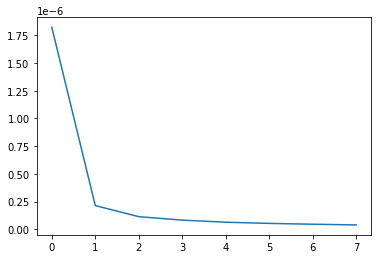

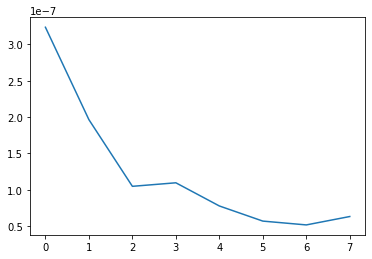

In [26]:
for phase in losses:
    plt.plot(range(len(losses[phase])), losses[phase])
    plt.show()

c:\Users\ASUS\Anaconda3\envs\ml_env\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

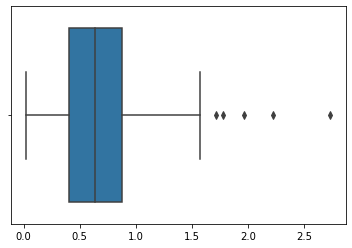

In [ ]:
sns.boxplot(mae)

In [ ]:
mae[abs(mae - np.mean(mae)) > 1.5 * np.std(mae)]

array([1.474667 , 1.5705105, 1.7142782, 1.4578534, 1.7738016, 1.5190198,
       1.961202 , 2.7335377, 2.222128 ], dtype=float32)

In [ ]:
threshold = np.mean(mae) + 1.5 * np.std(mae)
threshold

1.4349856227636337

In [27]:
maes = {'train': [], 'test': []}

with torch.set_grad_enabled(False):
    for phase in ('train', 'test'):
        for row in tqdm(dataloaders[phase]):
            row = row.float().to(device)
            out = model(row)
            mae = np.abs(out.detach().numpy() - row.detach().numpy()).sum(axis=1)
            maes[phase].append(mae)

  0%|          | 0/11719 [00:00<?, ?it/s]

  0%|          | 0/11894 [00:00<?, ?it/s]

In [28]:
train_maes = np.concatenate(maes['train'])
test_maes = np.concatenate(maes['test'])

In [29]:
train_maes.std(), test_maes.std()

(0.029300071, 0.03342271)

In [31]:
train_thresh = np.mean(train_maes) + 2.5 * np.std(train_maes)
test_thresh = np.mean(test_maes) + 2.5 * np.std(test_maes)

In [32]:
train_thresh, test_thresh

(0.10460693016648293, 0.11514349654316902)

Text(0.5, 1.0, 'Test MAE distribution')

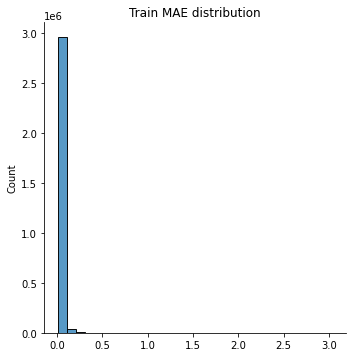

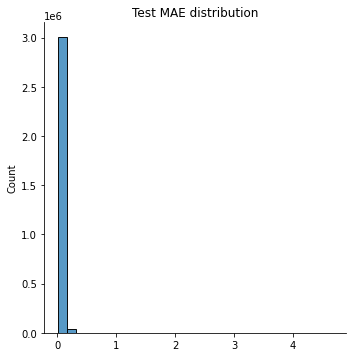

In [37]:
sns.displot(train_maes, bins=30)
plt.title('Train MAE distribution')
sns.displot(test_maes, bins=30)
plt.title('Test MAE distribution')

In [33]:
np.save('train_maes.npy', train_maes)
np.save('test_maes.npy', test_maes)

In [39]:
result = np.concatenate([train_maes > train_thresh, test_maes > test_thresh])

In [40]:
result.shape

(6044797,)

In [41]:
submission_df = pd.DataFrame(data={
    'event_id': df.index,
    'predictions': result * 1
})

In [48]:
submission_df.to_csv('submission.csv', index=False)

In [47]:
submission_df['predictions'].value_counts()

0    5927354
1     117443
Name: predictions, dtype: int64